In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
sys.path.insert(0,'../environments/'); import gw
sys.path.insert(0,'../environments/'); import gridworld_plotting as gp
sys.path.insert(0,'../rl_network/'); import ac
sys.path.insert(0,'../memory/'); import episodic as ec

import torch
from scipy.stats import entropy

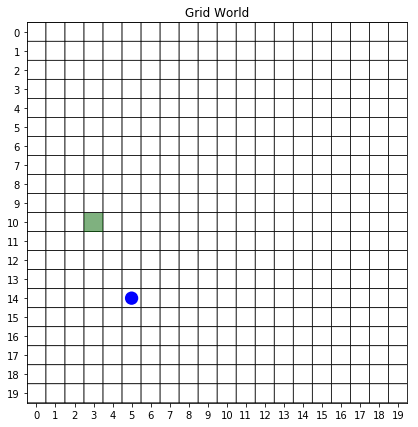

In [2]:
rows, columns = 20, 20
env = gw.GridWorld(rows=rows,cols=columns,
                   rewards = {(10,3):1},#rewards={(int(rows/2),int(columns/2)):1},#
                   step_penalization=-0.01,
                   rho=0.0,
                   rewarded_action = None)
fig = gw.plotWorld(env,current_state=True,scale=0.35, ax_labels=True)

In [3]:
agent_params = {
    'load_model':  False,
    'load_dir':     f'../data/outputs/gridworld/openfield{rows}{columns}_r{list(env.rewards.keys())[0][0]}{list(env.rewards.keys())[0][1]}.pt',
    'freeze_w':    False,

    'input_dims':  env.observation.shape,
    'action_dims': len(env.action_list),
    'hidden_types':['conv','pool','linear'],
    'hidden_dims': [None, None, 500],

    'rfsize':      5,
    'stride':      1,
    'padding':     1,
    'dilation':    1,

    'gamma':       0.98,
    'eta':         5e-4,

    'use_EC':      True,
    'EC':          {},
    'cachelim':    300,
    'mem_temp':    0.3
}

In [4]:
agent = ac.make_agent(agent_params)
episodic_memory = ec.ep_mem(agent, 300)


In [5]:
# get observation
print(f'state is {env.oneD2twoD(env.state)}')
state = torch.Tensor([env.get_observation()])

p_, v_, lin_act_ = agent(state, lin_act = 2)
lin_act = tuple(np.round(lin_act_.data[0].numpy(), 4))

state is (14, 5)


In [13]:
choice = agent.select_action(p_, v_)
action = env.action_list[choice][0]

mem_dict = {}

#take a step in the environment
s_1d, reward, isdone = env.move(action)
print(reward)
mem_dict['activity'] = lin_act
mem_dict['action'] = choice
mem_dict['delta'] = 1
mem_dict['timestamp'] = 0
mem_dict['readable'] = env.oneD2twoD(env.state)
mem_dict['trial'] = 0 

#print(mem_dict)
episodic_memory.add_mem(mem_dict)

-0.01


In [14]:
print(episodic_memory.cache_list.values())

dict_values([[array([[  nan,   inf],
       [ 1.  ,  0.  ],
       [  nan,   inf],
       [-0.01,  0.  ],
       [  nan,   inf],
       [  nan,   inf]]), 0, (13, 4)]])


In [22]:
recency_env = ec.calc_env(halfmax = 200)
mem_entropy = 0.3

ent = {}
envs = []
for j in range(0,1000,100):
    ent[f'{j}']=[]
    recency_env = ec.calc_env(halfmax = j)
    envs.append(recency_env)
    for i in range(0, 1000):
        memory_policy = torch.from_numpy(
        episodic_memory.recall_mem(lin_act,
                            i,
                            decay=recency_env,
                            mem_temp=mem_entropy))
        
        ent[f'{j}'].append(entropy(memory_policy))
    #print(memory_policy)
    #print(entropy(memory_policy))

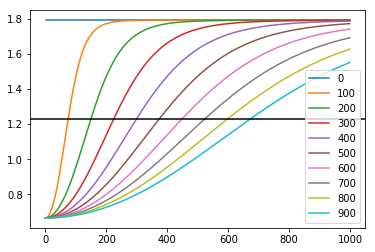

In [39]:
for ind, j in enumerate(list(ent.keys())):
    plt.plot(ent[j], label = j )

y = np.nanmin(ent['100']) + (np.nanmax(ent['100']) - np.nanmin(ent['100']))/2

plt.axhline(y, xmin=0, xmax=1000, color='k')
plt.legend(loc=0)

0.6658727032076585
1.7917594692164547
1.1258867660087963


In [40]:
entropy(ac.softmax([1,1,1,1,1,1]))

1.791759469228055